In [75]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.nonparametric import smoothers_lowess as lowess

from core import qlearning as q
from core import prices as pr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Variation du $\beta$:

Intuition : 
- Plus le $\epsilon$ tend vite vers 0 ($\beta$ grand), plus on optimise, plus les profits vont être ceux de Nash
- Il y aura une valeur de $\beta$ moyenne pour lequelle il y aura collusion 
- Si $\epsilon$ trop proche de 1, tend vers 0 trop lentement ($\beta$ très petit) il n'y aura pas de stratégie (tout le temps action aléatoire)


In [3]:
# Path to the pickle file
pickle_file_path = '/Volumes/OS-Data/Suzie_data/RLandPricing/data/data_epsilon.pkl'

# Open the file in binary read mode
with open(pickle_file_path, 'rb') as file:
    aggregated_agents = pickle.load(file)

# Now, "aggregated_agents" contains the object saved in the pickle file
print(aggregated_agents)

[array([[0.28630152, 0.2694895 ],
       [0.27009417, 0.28503904],
       [0.29657472, 0.28218592],
       ...,
       [0.28716356, 0.26793999],
       [0.2507236 , 0.26902398],
       [0.26156524, 0.23983205]]), array([[0.26648338, 0.2661323 ],
       [0.27997979, 0.2568926 ],
       [0.3089437 , 0.22696048],
       ...,
       [0.28341157, 0.29117644],
       [0.28320037, 0.3021792 ],
       [0.3064068 , 0.28695711]]), array([[0.27065959, 0.29495013],
       [0.28495002, 0.29664019],
       [0.29231392, 0.2607963 ],
       ...,
       [0.27126214, 0.27561505],
       [0.29133546, 0.26769206],
       [0.25983364, 0.31515006]]), array([[0.28887009, 0.28788279],
       [0.26400011, 0.27130897],
       [0.28247814, 0.27253244],
       ...,
       [0.28434863, 0.27684221],
       [0.27985989, 0.29061565],
       [0.29734287, 0.26075573]])]


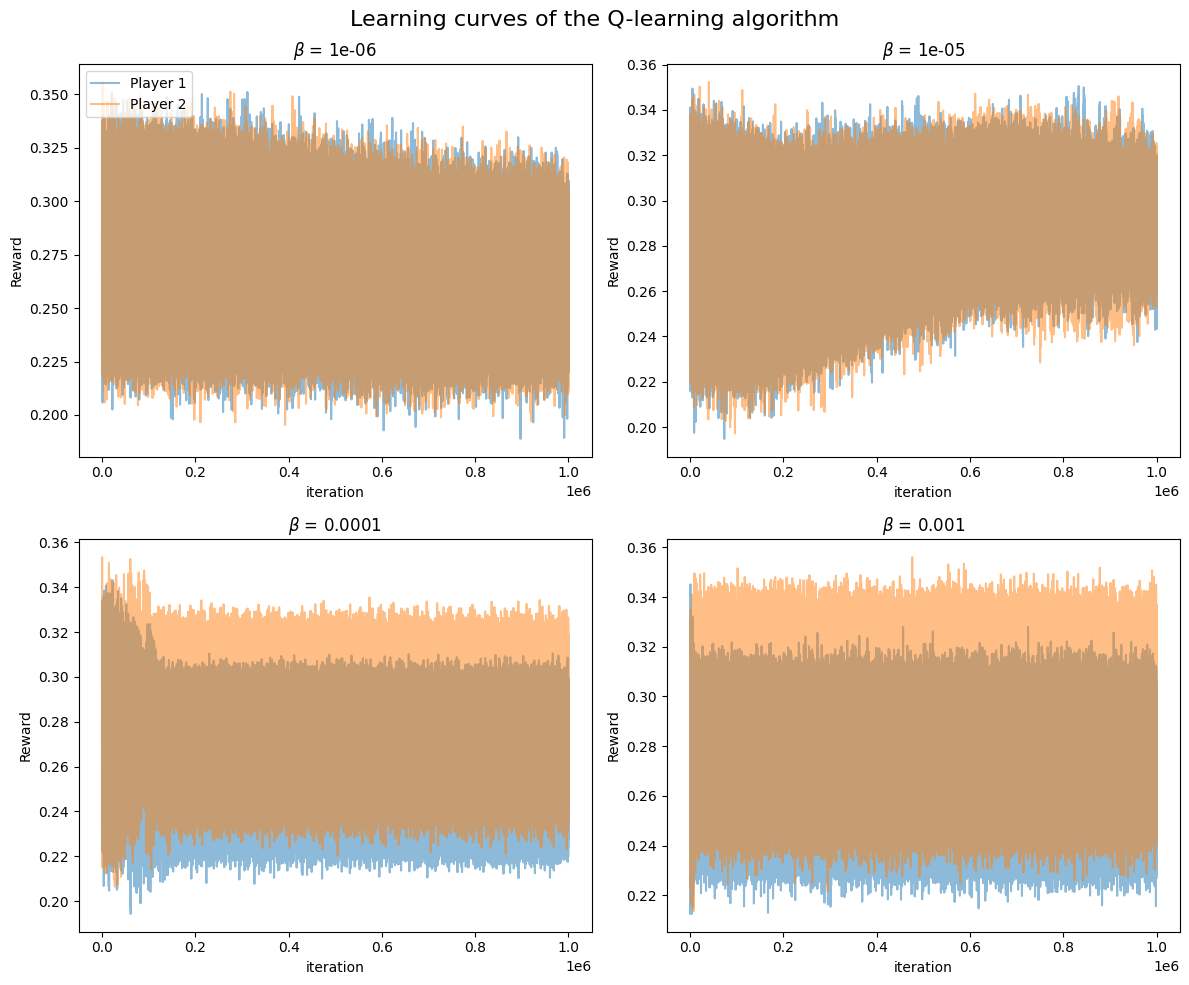

In [4]:
num_players = 2
num_graphs = len(aggregated_agents)
beta = [10**(-6),10**(-5),10**(-4),10**(-3)]

# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the axes array to iterate over the subplots
axes = axes.flatten()

# Loop to iterate through the periods and subplots
for graph_num in range(num_graphs):
    ax = axes[graph_num]
    num_players = len(aggregated_agents[graph_num][0])
    # Plot curves for each player in the subplot
    for player in range(num_players):
        ax.plot(aggregated_agents[graph_num][:, player], alpha=0.5, label=f'Player {player + 1}')
    
    # Set the title of the subplot with the corresponding period
    ax.set_title(f'$\\beta$ = {beta[graph_num]}')
    
    # Set the labels of the subplot
    ax.set_xlabel('iteration')
    ax.set_ylabel('Reward')

    # Add a legend to the first subplot
    if graph_num == 0:
        ax.legend(loc='upper left') 

# Remove any unused subplots
if num_graphs < 4:
    for i in range(num_graphs, 4):
        fig.delaxes(axes[i])

# Create a legend in the first subplot
if graph_num == 0:
         # Legend in the top-left corner
        ax.spines['top'].set_visible(True)  # Show top spine
        ax.spines['right'].set_visible(True)  # Show right spine
        ax.spines['bottom'].set_visible(True)  # Show bottom spine
        ax.spines['left'].set_visible(True)  # Show left spine

# Get the legend handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()


fig.suptitle('Learning curves of the Q-learning algorithm', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [5]:
prices = pr.PriceOptimizer()
collusion_profit, collusion_prices = prices.CollusionPrice()
nash_profit, nash_prices = prices.NashPrice()
RN = nash_profit
RC = collusion_profit
    
Rmean = np.zeros((len(aggregated_agents), 2))
DRmean = np.zeros((len(aggregated_agents), 2))   
    
for i in range (len(aggregated_agents)): 
    for j in range (2):
        Rmean[i][j] = aggregated_agents[i][-100:,j].mean()
        DRmean[i][j] = (Rmean[i][j] - RN)/(RC - RN) 

print(DRmean)

[[0.3506698  0.35228129]
 [0.61449699 0.60373636]
 [0.3584802  0.51388601]
 [0.41199617 0.59069353]]


[0.35147555 0.60911667 0.43618311 0.50134485]


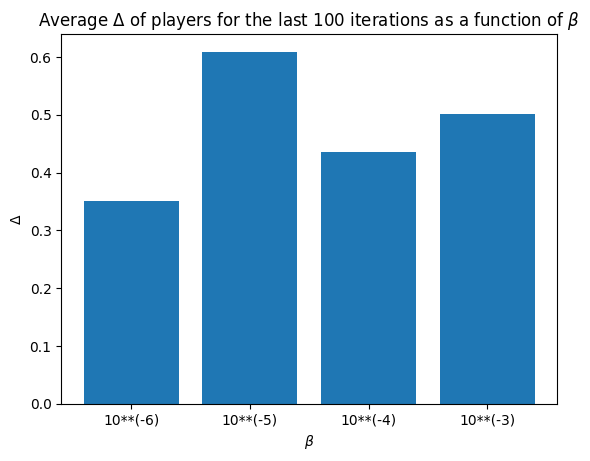

In [6]:
av = np.mean(DRmean, axis=1)
print(av)
plt.bar(['10**(-6)','10**(-5)','10**(-4)','10**(-3)'],av)
plt.xlabel('$\\beta$')
plt.ylabel('$\\Delta$')
plt.title('Average $\\Delta$ of players for the last 100 iterations as a function of $\\beta$')
plt.show()

In [63]:
import numpy as np
#import pickle
import time

from core import qlearning as q

start = time.time()
aggregated_agents = []
time_data = []
for beta in [10**(-6), 10**(-5), 10**(-4), 10**(-3)]:
    total_rewards = []

    for loop in range(20):
        print("Loop:", loop, "beta:", beta)
        agents = [q.Agent(beta=beta) for _ in range(2)]
        env = q.Env()

        temps = []
        rewards = []
        epsilon = []
        prices = []

        # Initialization of prices p0 (done directly in each agent)
        for agent in agents:
            agent.p = np.random.choice(agent.A)

        # Initialization of state
        s_t = env([agent.p for agent in agents])[1]
        for agent in agents:
            agent.s_t = s_t

        s_ind = agents[0].find_index(agents[0].s_t)
        for agent in agents:
            agent.s_ind = s_ind

        # Iterative phase
        for t in range(10):
            for agent in agents:
                agent.a_ind = agent.get_next_action()

            s_t1 = env([agent.A[agent.a_ind] for agent in agents])[1]
            for agent in agents:
                agent.s_t1 = s_t1

            s_ind1 = agents[0].find_index(agents[0].s_t1)
            for agent in agents:
                agent.s_ind1 = s_ind1

            temps.append(t)
            ret = env(s_t1)
            quant, price, cost = ret

            re = ret[0]*ret[1]-ret[0]*ret[2]
            rewards.append(re)
            epsilon_values = [agent.epsilon for agent in agents]
            epsilon.append(epsilon_values)
            prices.append([agent.p for agent in agents])

            for i, agent in enumerate(agents):
                agent.updateQ(q=quant[i], p=price[i], c=cost[i], t=t)

        total_rewards.append(rewards)

    aggregated_agents.append(np.array(total_rewards))

print(aggregated_agents)

Loop: 0 beta: 1e-06
Loop: 1 beta: 1e-06
Loop: 2 beta: 1e-06
Loop: 3 beta: 1e-06
Loop: 4 beta: 1e-06
Loop: 5 beta: 1e-06
Loop: 6 beta: 1e-06
Loop: 7 beta: 1e-06
Loop: 8 beta: 1e-06
Loop: 9 beta: 1e-06
Loop: 10 beta: 1e-06
Loop: 11 beta: 1e-06
Loop: 12 beta: 1e-06
Loop: 13 beta: 1e-06
Loop: 14 beta: 1e-06
Loop: 15 beta: 1e-06
Loop: 16 beta: 1e-06
Loop: 17 beta: 1e-06
Loop: 18 beta: 1e-06
Loop: 19 beta: 1e-06
Loop: 0 beta: 1e-05
Loop: 1 beta: 1e-05
Loop: 2 beta: 1e-05
Loop: 3 beta: 1e-05
Loop: 4 beta: 1e-05
Loop: 5 beta: 1e-05
Loop: 6 beta: 1e-05
Loop: 7 beta: 1e-05
Loop: 8 beta: 1e-05
Loop: 9 beta: 1e-05
Loop: 10 beta: 1e-05
Loop: 11 beta: 1e-05
Loop: 12 beta: 1e-05
Loop: 13 beta: 1e-05
Loop: 14 beta: 1e-05
Loop: 15 beta: 1e-05
Loop: 16 beta: 1e-05
Loop: 17 beta: 1e-05
Loop: 18 beta: 1e-05
Loop: 19 beta: 1e-05
Loop: 0 beta: 0.0001
Loop: 1 beta: 0.0001
Loop: 2 beta: 0.0001
Loop: 3 beta: 0.0001
Loop: 4 beta: 0.0001
Loop: 5 beta: 0.0001
Loop: 6 beta: 0.0001
Loop: 7 beta: 0.0001
Loop: 8 beta

In [9]:
len(aggregated_agents[0][0])

10

In [15]:
aggregated_agents

[array([[[0.1272193 , 0.38169148],
         [0.29199697, 0.29199697],
         [0.39100528, 0.27844426],
         [0.2368855 , 0.35316849],
         [0.24589853, 0.1964421 ],
         [0.41563149, 0.23844847],
         [0.11990343, 0.33167768],
         [0.19274081, 0.39868283],
         [0.1993333 , 0.42692133],
         [0.352927  , 0.1642367 ]],
 
        [[0.26545967, 0.26545967],
         [0.31545203, 0.14155273],
         [0.20213876, 0.20213876],
         [0.27238067, 0.18222362],
         [0.38132184, 0.18813575],
         [0.22006659, 0.28502892],
         [0.34355771, 0.27960543],
         [0.17675391, 0.34130865],
         [0.3191    , 0.17014698],
         [0.27129972, 0.33137851]],
 
        [[0.26545967, 0.26545967],
         [0.40758249, 0.23631843],
         [0.39100528, 0.27844426],
         [0.41396382, 0.19650313],
         [0.30793852, 0.3426892 ],
         [0.3010206 , 0.33414345],
         [0.20213876, 0.20213876],
         [0.14600414, 0.4155563 ],
         [0.39

In [28]:
aggregated_agents[3][19][:-5,0]

array([0.20864308, 0.27844426, 0.31359405, 0.26545967, 0.33854712])

In [33]:
old = np.array(aggregated_agents).mean(axis=1)

In [36]:
len(old[0,0])

2

In [68]:
def loess_regression(x, y, span, degree=1):
    lowess = sm.nonparametric.lowess(y, x, frac=span, it=0, is_sorted=True)
    return lowess[:, 1]

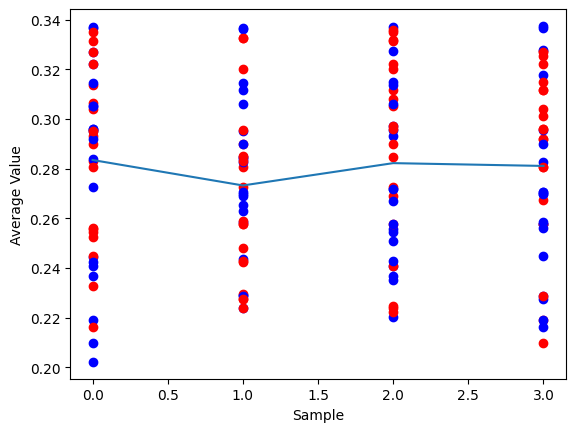

In [79]:
# Parameters
n_params = len(aggregated_agents)

X = []
Y = []


# Loop through each parameter  
for param_ind in range(n_params):

  # Extract data for this parameter
  data = aggregated_agents[param_ind]

  # Loop through each sample
  for sample_ind in range(data.shape[0]):
  
    # Take data from last iteration
    last_iter = data[sample_ind][-5:]

    # Calculate mean across players
    mean = np.mean(last_iter, axis=1)

    # Plot the point
    plt.scatter(param_ind, mean[0],
                color='b', marker='o', label='player1')
    
    plt.scatter(param_ind, mean[1],
                color='r', marker='o', label='player2')
    
    X.append(param_ind)
    X.append(param_ind)
    Y.append(mean[0])
    Y.append(mean[1])
    

  # End of sample loop
reg = lowess.lowess(Y, X)[:,1]
plt.plot(X,reg)

# Customize plot
plt.xlabel('Sample')  
plt.ylabel('Average Value')

  
plt.show()

La régression LOESS est particulièrement adaptée quand:
Les valeurs des prédicteurs X sont discrètes ou peu denses
Mais la relation avec Y est lisse/continue
Il y a de la variabilité locale dans les valeurs de Y pour un même X

In [ ]:
interet = 

In [ ]:
av = aggregated_agents[:][:][0]
print(av)
plt.scatter([1,2,3,4],av)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\Delta$')
plt.title('Average $\\Delta$ of players for the last 100 iterations as a function of the number of $\\alpha$')
plt.show()